# Input Packages

In [6]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import time
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import f1_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Input data

In [7]:
PATH_DATA_RAW = '../input/'

In [8]:
entbase_raw = pd.read_csv(PATH_DATA_RAW + "1baseinfo.csv")
alter_raw = pd.read_csv(PATH_DATA_RAW + "2alterinfo.csv")
branch_raw = pd.read_csv(PATH_DATA_RAW + "3branchinfo.csv")
invest_raw = pd.read_csv(PATH_DATA_RAW + "4investinfo.csv")
right_raw = pd.read_csv(PATH_DATA_RAW + "5rightinfo.csv")
project_raw = pd.read_csv(PATH_DATA_RAW + "6projectinfo.csv")
case_raw = pd.read_csv(PATH_DATA_RAW + "7caseinfo.csv")
dishonest_raw = pd.read_csv(PATH_DATA_RAW + "8dishonestinfo.csv")
recruit_raw = pd.read_csv(PATH_DATA_RAW + "9jobinfo.csv")

In [9]:
train_raw = pd.read_csv(PATH_DATA_RAW + "train.csv")
test_raw = pd.read_csv(PATH_DATA_RAW + "evaluation_public.csv")

# Preprocessing

### Base

In [10]:
#1
entbase = entbase_raw.copy()
entbase['CreateYear'] = 2018 - entbase['CreateYear']

In [6]:
entbase.head(3)

,EID,CreateYear,TradeType,RegisteredCapital,Type,Feature1,Feature2,Feature3,Feature4,Feature5
0,732046267,38,51.0,480.0,13,25.0,1.0,98041.0,17.0,NaN
1,802231616,25,74.0,30.0,13,0.0,1.0,570.0,3.0,NaN
2,533129872,3,69.0,1000.0,6,2.0,1.0,1000.0,0.0,NaN


In [7]:
# 不同行业平均资产规模不同，将注册资本转换为企业在其所属行业内的相对资产规模
avg_capital_tradetype = entbase.groupby('TradeType', as_index=False).RegisteredCapital.mean()
avg_capital_tradetype.head()

,TradeType,RegisteredCapital
0,1.0,642.345588
1,2.0,298.529412
2,3.0,370.085616
3,4.0,243.155080
4,5.0,1220.463492


In [8]:
avg_capital_tradetype.columns=['TradeType','AvgTradeTypeCapital']   # 替换字段名，避免和原字段重名

In [9]:
# 拼表
entbase = pd.merge(entbase, avg_capital_tradetype, on='TradeType', how='left')

In [10]:
entbase.sort_values('TradeType').head()

,EID,CreateYear,TradeType,RegisteredCapital,Type,Feature1,Feature2,Feature3,Feature4,Feature5,AvgTradeTypeCapital
78957,1031430028,7,1.0,100.0,7,4.0,1.0,NaN,5.0,NaN,642.345588
286274,309583851,4,1.0,100.0,7,6.0,2.0,NaN,7.0,NaN,642.345588
294901,494464080,5,1.0,3.0,7,NaN,2.0,NaN,0.0,NaN,642.345588
175537,593218945,15,1.0,10.0,8,NaN,1.0,NaN,1.0,NaN,642.345588
57499,945750581,6,1.0,100.0,7,0.0,2.0,NaN,0.0,NaN,642.345588


In [11]:
entbase['TradeTypeCapitalSize'] = entbase['RegisteredCapital'] / entbase['AvgTradeTypeCapital']

In [12]:
entbase.shape

(300000, 12)

### Alter

In [13]:
#2
alter_raw = alter_raw.drop_duplicates()
alter = alter_raw.copy()

In [14]:
alter['AlterBefore'].describe()

count     28322
unique     2005
top          10
freq       4186
Name: AlterBefore, dtype: object

In [15]:
#正则表达式，取出数字部分
alter['AlterBefore'] = alter['AlterBefore'].str.extract('(?P<AlterBefore>[0-9]+)', expand=True)
alter['AlterAfter'] = alter['AlterAfter'].str.extract('(?P<AlterAfter>[0-9]+)', expand=True)

In [16]:
alter.shape

(238268, 5)

In [17]:
alter.drop_duplicates(inplace=True)
alter['AlterBefore'] = alter['AlterBefore'][alter['AlterBefore'].isnull()==False].apply(lambda x: int(x))
alter['AlterAfter'] = alter['AlterAfter'][alter['AlterAfter'].isnull()==False].apply(lambda x: int(x))

In [18]:
alter['ALTDIFF'] = alter['AlterAfter'] - alter['AlterBefore']

In [19]:
alter['ALTDIFF'].describe()

count     27253.000000
mean       1429.294280
std       13015.074676
min     -120100.000000
25%          82.000000
50%         200.000000
75%         700.000000
max      969160.000000
Name: ALTDIFF, dtype: float64

In [20]:
alter.columns

Index(['EID', 'AlterNumber', 'AlterDate', 'AlterBefore', 'AlterAfter',
       'ALTDIFF'],
      dtype='object')

In [21]:
#如赛题描述，仅AlterNumber为“05”和“27”有数据
alter['AlterNumber'][alter['AlterBefore'].isnull() == False].unique()

array(['05', '27'], dtype=object)

In [22]:
#为了拿到同一变更事项下的统计特征，将alter表按照 05  27 拆分
alter_05 = alter[alter['AlterNumber'] == '05']
alter_05.head()

,EID,AlterNumber,AlterDate,AlterBefore,AlterAfter,ALTDIFF
11,378581293,05,2014-09,50.0,200.0,150.0
13,1195396819,05,2015-01,10.0,1200.0,1190.0
34,852219791,05,2014-11,50.0,500.0,450.0
46,1128235944,05,2015-01,50.0,300.0,250.0
51,1128235945,05,2014-06,50.0,100.0,50.0


In [23]:
alter_05_sum = alter_05.groupby(['EID'])['ALTDIFF'].sum().reset_index()
alter_05_sum.head()

,EID,ALTDIFF
0,59589,400.0
1,83801,97.0
2,83836,450.0
3,83898,700.0
4,115497,300.0


In [24]:
#重命名 （防止表连接时名字起冲突）
alter_05_sum.columns = ['EID', 'alt_05_sum']

In [25]:
alter_05 = pd.merge(alter_05,alter_05_sum,how='left',on='EID')
alter_05.head()

,EID,AlterNumber,AlterDate,AlterBefore,AlterAfter,ALTDIFF,alt_05_sum
0,378581293,05,2014-09,50.0,200.0,150.0,150.0
1,1195396819,05,2015-01,10.0,1200.0,1190.0,1190.0
2,852219791,05,2014-11,50.0,500.0,450.0,450.0
3,1128235944,05,2015-01,50.0,300.0,250.0,250.0
4,1128235945,05,2014-06,50.0,100.0,50.0,50.0


In [26]:
#至此，“变更事项为05时，变更数量之和” 这一特征就做好了
#但是该表中，有多条记录，如何按照EID聚合呢？对于这类于时间有关的问题，可以按照时间先后顺序取得最合适的一行记录
#比如以下例子中，取2015年4月的

In [27]:
alter_05[alter_05['EID'] == 851646734]

,EID,AlterNumber,AlterDate,AlterBefore,AlterAfter,ALTDIFF,alt_05_sum
22382,851646734,05,2015-04,3000.0,3260.0,260.0,560.0
22383,851646734,05,2014-04,2700.0,3000.0,300.0,560.0


In [28]:
def get_latest_alter(alter):
    del alter['AlterNumber']
    alter = alter.sort_values(['EID','AlterDate'], ascending=False)
    alter['cumcount'] = alter.groupby(['EID']).cumcount()
    alter = alter[alter['cumcount'] == 0]
    del alter['cumcount']
    return alter

In [29]:
alter_05 = get_latest_alter(alter_05)
alter_05[alter_05['EID'] == 851646734]

,EID,AlterDate,AlterBefore,AlterAfter,ALTDIFF,alt_05_sum
22382,851646734,2015-04,3000.0,3260.0,260.0,560.0


In [30]:
#最后，这张表中的日期是 yyyy-mm的形式，为了转化为数字特征
#我们做进一步的处理: 拆成年 和  月

In [31]:
alter_05['alter_05_year'] = alter_05['AlterDate'].str.split('-').str[0].apply(lambda x: int(x))
alter_05['alter_05_month'] = alter_05['AlterDate'].str.split('-').str[1].apply(lambda x: int(x))
del alter_05['AlterDate']
alter_05.head()

,EID,AlterBefore,AlterAfter,ALTDIFF,alt_05_sum,alter_05_year,alter_05_month
19652,1465175824,50.0,300.0,250.0,250.0,2015,3
7613,1465170707,100.0,300.0,200.0,200.0,2015,1
6779,1465110513,10.0,50.0,40.0,40.0,2014,4
19378,1464980325,50.0,200.0,150.0,150.0,2014,12
6977,1464980096,500.0,1500.0,1000.0,1000.0,2014,8


In [32]:
alter_05.rename(columns=lambda x:x.replace('ALTDIFF','ALTDIFF05'), inplace=True)

In [33]:
#同样的步骤，对alter no 为27时的数据，再做一遍
#复制一遍代码

In [34]:
alter_27 = alter[alter['AlterNumber'] == '27']
alter_27_sum = alter_27.groupby(['EID'])['ALTDIFF'].sum().reset_index()
alter_27_sum.columns = ['EID', 'alt_27_sum']
alter_27 = pd.merge(alter_27,alter_27_sum,how='left',on='EID')
alter_27 = get_latest_alter(alter_27)
alter_27['alter_27_year'] = alter_27['AlterDate'].str.split('-').str[0].apply(lambda x: int(x))
alter_27['alter_27_month'] = alter_27['AlterDate'].str.split('-').str[1].apply(lambda x: int(x))
del alter_27['AlterDate']
alter_27.rename(columns=lambda x:x.replace('ALTDIFF','ALTDIFF27'), inplace=True)

In [35]:
#对于这类有重复的代码，可以写成函数

#### Alter主表

In [36]:
#回到完整的alter表，除了05 27时的变更数量特征，还有哪些特征可以挖掘？

In [37]:
def divide_alter(alter,le):
    le.fit(alter['ALTERNO'])
    alter['ALTERNO'] = le.transform(alter['ALTERNO']) 
    alter = alter.sort_values(['EID','ALTDATE'], ascending=True)
    alter['alt_year'] = alter['ALTDATE'].str.split('-').str[0].apply(lambda x: int(x))
    alter['alt_month'] = alter['ALTDATE'].str.split('-').str[1].apply(lambda x: int(x))
    alter = get_alter_year_count(alter,'alter_count_2015','alt_year',2015)
    for i in range(12):
        alter = divide_alter_no(alter, i)
    alter['alter_count'] = alter.groupby(['EID']).cumcount() + 1
    idx = alter.groupby(['EID'])['alter_count'].transform(max) == alter['alter_count']
    alter = alter[idx]
    alter['alt_gap_month'] = (2016 - alter['alt_year']) * 12 + 12 - alter['alt_month'] + 8
    alter = alter.drop(['alt_year','alt_month','ALTAF','ALTBE','ALTERNO','ALTDATE'], axis = 1)
    return alter,le

In [38]:
alter = alter_raw.copy()

In [39]:
alter['AlterNumber'].unique()

array(['13', '03', '10', '12', '05', '01', '02', '04', '99', '27',
       'A_015', '14'], dtype=object)

In [40]:
le = preprocessing.LabelEncoder()
le.fit(alter['AlterNumber'])
alter['AlterNumber'] = le.transform(alter['AlterNumber']) 

In [41]:
alter = alter.sort_values(['EID','AlterDate'], ascending=True)
alter['alt_year'] = alter['AlterDate'].str.split('-').str[0].apply(lambda x: int(x))
alter['alt_month'] = alter['AlterDate'].str.split('-').str[1].apply(lambda x: int(x))

In [42]:
alter[(alter['alt_year'] == 2015)&(alter['EID'] == 83801)]

,EID,AlterNumber,AlterDate,AlterBefore,AlterAfter,alt_year,alt_month
171703,83801,6,2015-06,NaN,NaN,2015,6
171707,83801,11,2015-06,NaN,NaN,2015,6
171708,83801,5,2015-06,NaN,NaN,2015,6
171710,83801,2,2015-06,NaN,NaN,2015,6
171711,83801,0,2015-06,NaN,NaN,2015,6


In [43]:
alter['year_count'] = 1
alter_tmp = alter[alter['alt_year'] == 2015].groupby(['EID'])['year_count'].sum().reset_index()
del alter['year_count']
alter_tmp.head()

,EID,year_count
0,26268,1
1,59589,1
2,83669,1
3,83766,1
4,83801,5


In [44]:
#将以上信息聚合到alter主表中，我们就得到了，一个企业（EID）下，2015年的变更总次数
#将这些步骤整合成函数：
def get_alter_year_count(df,col_name,year_col_name,year):
    df['tmp'] = 1
    df_tmp = df[df[year_col_name] == year].groupby(['EID'])['tmp'].sum()
    df_tmp = pd.DataFrame({'EID':df_tmp.index, col_name:df_tmp.values})
    del df['tmp']
    df = pd.merge(df, df_tmp, how='left', on='EID')
    #对于2015年没记录的企业，空值填充为0 （实际意义）
    df[col_name] = df[col_name].fillna(0)
    return df

In [45]:
# alter = get_alter_year_count(alter,'alter_count_2013','alt_year',2013)
# alter = get_alter_year_count(alter,'alter_count_2014','alt_year',2014)
alter = get_alter_year_count(alter,'alter_count_2015','alt_year',2015)

In [46]:
def divide_alter_no(df, num):
    col_name = 'alter_count_' + str(num)
    df[col_name] = 0
    df[col_name][df['AlterNumber'] == num] = 1
    df_tmp = df.groupby(['EID'])[col_name].sum()
    df_tmp = pd.DataFrame({'EID':df_tmp.index, col_name:df_tmp.values})
    del df[col_name]
    df = pd.merge(df, df_tmp, how='left', on='EID')
    return df

In [47]:
# for i in range(12):
#     alter = divide_alter_no(alter, i)

In [48]:
#同样地，为了得到一家企业的信息，需要对alter表进行聚合，
#再统计得到一家企业全部年份的变更次数值，然后直接按照变更次数排序，取出最后一行记录
alter['alter_count'] = alter.groupby(['EID']).cumcount() + 1
idx = alter.groupby(['EID'])['alter_count'].transform(max) == alter['alter_count']
alter = alter[idx]

In [49]:
alter.head()

,EID,AlterNumber,AlterDate,AlterBefore,AlterAfter,alt_year,alt_month,alter_count_2015,alter_count
0,26171,6,2014-02,NaN,NaN,2014,2,0.0,1
1,26268,6,2015-03,NaN,NaN,2015,3,1.0,1
12,26330,5,2014-08,NaN,NaN,2014,8,0.0,11
14,26594,3,2014-09,NaN,NaN,2014,9,0.0,2
15,59589,4,2015-07,100,500,2015,7,1.0,1


In [50]:
alter = alter.drop(['AlterNumber','AlterDate','AlterBefore','AlterAfter'], axis = 1)

#### 最后，将05 27的变更信息整合起来，得到最终的变更特征表

In [51]:
alter_05 = alter_05.drop(['AlterBefore','AlterAfter'], axis = 1)
alter_27 = alter_27.drop(['AlterBefore','AlterAfter'], axis = 1)

In [52]:
alter = pd.merge(alter, alter_05, how='left', on='EID')
alter = pd.merge(alter, alter_27, how='left', on='EID')

In [53]:
alter.head()

,EID,alt_year,alt_month,alter_count_2015,alter_count,ALTDIFF05,alt_05_sum,alter_05_year,alter_05_month,ALTDIFF27,alt_27_sum,alter_27_year,alter_27_month
0,26171,2014,2,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26268,2015,3,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26330,2014,8,0.0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26594,2014,9,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59589,2015,7,1.0,1,400.0,400.0,2015.0,7.0,NaN,NaN,NaN,NaN


### Branch

In [54]:
branch_raw = branch_raw.drop_duplicates()
branch = branch_raw.copy()

In [55]:
#先检查注册年份 和 倒闭年份 直接 有没有逻辑错误

In [56]:
branch[branch.CloseYear < branch.RegYear].head()

,EID,BranchEID,SameProvince,RegYear,CloseYear
3125,788813847,pbr9998,0,2003,1998.0
4793,40352956,pbr14948,0,2004,2002.0
6292,1176563327,pbr15249,1,2005,1950.0
7033,1204284370,pbr34186,0,2005,1999.0
11374,1447052230,pbr30393,1,1996,1950.0


In [57]:
wrong_index = branch.CloseYear < branch.RegYear
branch.loc[wrong_index,'CloseYear'], branch.loc[wrong_index, 'RegYear'] = \
branch.loc[wrong_index,'RegYear'], branch.loc[wrong_index,'CloseYear']

In [58]:
del branch['BranchEID']
branch = branch.sort_values(['EID','RegYear'], ascending=True)

In [59]:
branch['branch_count'] = branch.groupby(['EID']).cumcount() + 1
branch.head()

,EID,SameProvince,RegYear,CloseYear,branch_count
26628,59590,1,2009.0,2012.0,1
66943,83669,0,2012.0,NaN,1
31528,103798,1,2001.0,2007.0,1
72250,103798,1,2002.0,NaN,2
38288,103798,1,2003.0,NaN,3


In [60]:
def get_annual_close(df, col_name, year_col_name, year):
    df[col_name] = 0
    df[col_name][(df[year_col_name].isnull() == False) & (df[year_col_name] <= year)] = 1
    df_tmp = df.groupby(['EID'])[col_name].sum()
    df_tmp = pd.DataFrame({'EID':df_tmp.index, col_name:df_tmp.values})
    del df[col_name]
    df = pd.merge(df, df_tmp, how='left', on='EID')
    return df

In [61]:
branch = get_annual_close(branch, 'branch_end_count_2015', 'CloseYear', 2015)

In [62]:
branch[branch['EID'] == 103798]

,EID,SameProvince,RegYear,CloseYear,branch_count,branch_end_count_2015
2,103798,1,2001.0,2007.0,1,2
3,103798,1,2002.0,NaN,2,2
4,103798,1,2003.0,NaN,3,2
5,103798,1,2006.0,2007.0,4,2


In [63]:
idx = branch.groupby(['EID'])['branch_count'].transform(max) == branch['branch_count']
branch = branch[idx]
branch.rename(columns=lambda x:x.replace('SameProvince','branch_same'), inplace=True)

In [64]:
branch['RegYear'] = 2018 - branch['RegYear']
branch['CloseYear'] = 2018 - branch['CloseYear']

### Dishonest

In [65]:
dishonest_raw = dishonest_raw.drop_duplicates()
dishonest_raw.shape

(2968, 4)

In [66]:
dishonest_raw.EID.nunique()

1007

In [67]:
dishonest_raw.head()

,EID,DishonestID,RegDate,CloseDate
0,782634767,432341,2014年08月,NaN
1,463954664,98741001,2015年03月,NaN
2,463954664,1349372,2015年03月,NaN
3,542420088,60556535,2014年10月,NaN
4,542420088,64318506,2014年10月,NaN


In [68]:
dishonest = dishonest_raw.copy()

In [69]:
# 处理日期格式
import re
dishonest['RegYear'] = dishonest['RegDate'].apply(lambda x: int(x[:4]))
dishonest['RegDate'] = dishonest['RegDate'].apply(lambda x: re.sub("\D", "", x)).apply(lambda x: int(x))
dishonest['CloseDate'] = dishonest['CloseDate'].str.replace('-','')

In [70]:
dishonest[dishonest.CloseDate.notnull()].head()

,EID,DishonestID,RegDate,CloseDate,RegYear
27,140291183,1265656,201503,201507,2015
30,866210991,915918,201412,201507,2014
234,1223289810,538385,201410,201507,2014
309,1053904529,652410,201411,201507,2014
324,409814216,571064,201409,201507,2014


In [71]:
dishonest.RegYear.describe()

count    2968.000000
mean     2014.496968
std         0.564054
min      2013.000000
25%      2014.000000
50%      2015.000000
75%      2015.000000
max      2015.000000
Name: RegYear, dtype: float64

In [72]:
# 将非空的结束日期转化为数值
dishonest['CloseDate'] = dishonest['CloseDate'][dishonest['CloseDate'].notnull()].apply(lambda x: int(x))

In [73]:
dishonest[dishonest.EID==140291183]

,EID,DishonestID,RegDate,CloseDate,RegYear
27,140291183,1265656,201503,201507.0,2015


In [74]:
# 最近三年每年内总共发生多少次失信记录
# 最近三年总共发生多少次失信
# 发生的失信记录中，有多少至今还未关闭

In [75]:
# 统计某一年发生的失信记录数
def dishonest_count(df, group_key, filter_key, filter_value, agg_col, new_col_name):
    new_df = df[df[filter_key]==filter_value].groupby(group_key).nunique()[[agg_col]]
    # 重命名列，以避免merge时冲突
    new_df.rename(columns=lambda x:x.replace(agg_col, new_col_name), inplace=True)
    return pd.merge(df, new_df, left_on=group_key, right_index=True,how='left').fillna({new_col_name:0})

# 统计还未注销的失信记录数
def dishonest_unclose_count(df, group_key, filter_key, agg_col, new_col_name):
    new_df = df[df[filter_key].isnull()].groupby(group_key).nunique()[[agg_col]]
    # 重命名列，以避免merge时冲突
    new_df.rename(columns=lambda x:x.replace(agg_col, new_col_name), inplace=True)
    return pd.merge(df, new_df, left_on=group_key, right_index=True,how='left').fillna({new_col_name:0})

In [76]:
dishonest = dishonest_count(dishonest, 'EID', 'RegYear', 2013, 'DishonestID', 'dis_count_2013')
dishonest[(dishonest.EID==542420088) & (dishonest.RegYear==2013)]

,EID,DishonestID,RegDate,CloseDate,RegYear,dis_count_2013
14,542420088,42401939,201310,NaN,2013,2.0
15,542420088,16065,201310,NaN,2013,2.0


In [77]:
dishonest = dishonest_count(dishonest, 'EID', 'RegYear', 2014, 'DishonestID', 'dis_count_2014')
dishonest = dishonest_count(dishonest, 'EID', 'RegYear', 2015, 'DishonestID', 'dis_count_2015')
dishonest = dishonest_unclose_count(dishonest, 'EID', 'CloseDate', 'DishonestID', 'dis_count_unclose')

In [78]:
dishonest.shape

(2968, 9)

In [79]:
dishonest[dishonest.EID==463954664]

,EID,DishonestID,RegDate,CloseDate,RegYear,dis_count_2013,dis_count_2014,dis_count_2015,dis_count_unclose
1,463954664,98741001,201503,NaN,2015,0.0,0.0,2.0,2.0
2,463954664,1349372,201503,NaN,2015,0.0,0.0,2.0,2.0


In [80]:
# 只取最近发生的失信记录中，取还没有注销的记录
dishonest['dis_count'] = dishonest.sort_values(['EID','RegDate','CloseDate'], ascending=[True, True, False])\
                            .groupby(['EID']).cumcount() + 1
idx = dishonest.groupby(['EID'])['dis_count'].transform(max) == dishonest['dis_count']
dishonest = dishonest[idx]

In [81]:
# 重命名
dishonest.rename(columns=lambda x:x.replace('RegDate','LastDisRegDate'), inplace=True)
dishonest.rename(columns=lambda x:x.replace('CloseDate','LastDisCloseDate'), inplace=True)
dishonest.rename(columns=lambda x:x.replace('RegYear','LastDisRegYear'), inplace=True)

In [82]:
dishonest.columns

Index(['EID', 'DishonestID', 'LastDisRegDate', 'LastDisCloseDate',
       'LastDisRegYear', 'dis_count_2013', 'dis_count_2014', 'dis_count_2015',
       'dis_count_unclose', 'dis_count'],
      dtype='object')

# Merge tables

In [83]:
del train_raw['EndDate']
del test_raw['PROB']

In [84]:
total = pd.concat([train_raw,test_raw])

In [85]:
total.shape

(299810, 2)

In [86]:
total = pd.merge(total, entbase, how='left', on='EID')
total = pd.merge(total, alter, how='left', on='EID')
total = pd.merge(total, branch, how='left', on='EID')
total = pd.merge(total, dishonest, how='left', on='EID')
total = total.apply(pd.to_numeric, errors='ignore')

In [87]:
total.shape

(299810, 39)

In [88]:
train = total[total['Y'].isnull() == False]
test = total[total['Y'].isnull() == True]
del test['Y']

In [89]:
train.columns

Index(['EID', 'Y', 'CreateYear', 'TradeType', 'RegisteredCapital', 'Type',
       'Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5',
       'AvgTradeTypeCapital', 'TradeTypeCapitalSize', 'alt_year', 'alt_month',
       'alter_count_2015', 'alter_count', 'ALTDIFF05', 'alt_05_sum',
       'alter_05_year', 'alter_05_month', 'ALTDIFF27', 'alt_27_sum',
       'alter_27_year', 'alter_27_month', 'branch_same', 'RegYear',
       'CloseYear', 'branch_count', 'branch_end_count_2015', 'DishonestID',
       'LastDisRegDate', 'LastDisCloseDate', 'LastDisRegYear',
       'dis_count_2013', 'dis_count_2014', 'dis_count_2015',
       'dis_count_unclose', 'dis_count'],
      dtype='object')

In [90]:
train[['AvgTradeTypeCapital','TradeTypeCapitalSize','RegisteredCapital','Y']].corr()

,AvgTradeTypeCapital,TradeTypeCapitalSize,RegisteredCapital,Y
AvgTradeTypeCapital,1.000000,0.000205,0.083024,-0.010032
TradeTypeCapitalSize,0.000205,1.000000,0.694695,-0.009861
RegisteredCapital,0.083024,0.694695,1.000000,-0.006858
Y,-0.010032,-0.009861,-0.006858,1.000000


In [91]:
del train['TradeTypeCapitalSize']
del test['TradeTypeCapitalSize']

# Train

### 尝试输出混淆矩阵

In [92]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [93]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [94]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean()\
                                        .sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

In [95]:
def evaluate(X, y):
    start = time.time()
    # AUC
    lgb_cv = lgb.cv(l_params, lgb.Dataset(X, label=y), 10000, nfold=5,\
                    verbose_eval=100, early_stopping_rounds=100)
    print('highest cv is: ',lgb_cv['auc-mean'][-1], 'round is: ',len(lgb_cv['auc-mean']))
    
    # F1-阈值
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4242)
    model = lgb.train(l_params, lgb.Dataset(x_train, label=y_train), len(lgb_cv['auc-mean']))
    y_pred_valid = model.predict(x_valid)
    best = 0
    index = 0
    for threshold in range(0,100,1):
        t = threshold/100.0
        tmp = f1_score(y_valid,y_pred_valid>t)
        if tmp > best:
            best = tmp
            index = t
            cm = confusion_matrix(y_valid,y_pred_valid>t)
    print('threshold is: ',index)
    print('f1-score is: ',best)
    plot_confusion_matrix(cm, classes=['0','1'], title='Confusion matrix')
    
    # final score
    print('final score is: ', lgb_cv['auc-mean'][-1]*0.7 + best*0.3)
    
    # 特征重要性
    importance_df = pd.DataFrame()
    importance_df["feature"] = list(x_train.columns)
    importance_df["importance"] = model.feature_importance(importance_type='split', iteration=-1)
    
    display_importances(importance_df)
    
    return lgb_cv, index

In [96]:
# lgb
l_params = {'metric': 'auc', 'learning_rate' : 0.1, \
          'max_depth': -1, 'max_bin': 20,  'objective': 'binary', 
          'feature_fraction': 0.8,'bagging_fraction': 0.9,\
          'bagging_freq': 2, 'num_leaves': 15,\
         'boosting_type': 'gbdt'}

In [97]:
train_cv = train.copy()
train_cv.shape

(150095, 38)

In [98]:
X = train_cv.drop(['EID', 'Y'], axis=1)
y = train_cv['Y']

In [99]:
X.columns

Index(['CreateYear', 'TradeType', 'RegisteredCapital', 'Type', 'Feature1',
       'Feature2', 'Feature3', 'Feature4', 'Feature5', 'AvgTradeTypeCapital',
       'alt_year', 'alt_month', 'alter_count_2015', 'alter_count', 'ALTDIFF05',
       'alt_05_sum', 'alter_05_year', 'alter_05_month', 'ALTDIFF27',
       'alt_27_sum', 'alter_27_year', 'alter_27_month', 'branch_same',
       'RegYear', 'CloseYear', 'branch_count', 'branch_end_count_2015',
       'DishonestID', 'LastDisRegDate', 'LastDisCloseDate', 'LastDisRegYear',
       'dis_count_2013', 'dis_count_2014', 'dis_count_2015',
       'dis_count_unclose', 'dis_count'],
      dtype='object')

[100]	cv_agg's auc: 0.657044 + 0.00339315
[200]	cv_agg's auc: 0.657943 + 0.00315244
[300]	cv_agg's auc: 0.657982 + 0.00277957
highest cv is:  0.6581022454039617 round is:  265
threshold is:  0.16
f1-score is:  0.3064876957494407
Confusion matrix, without normalization


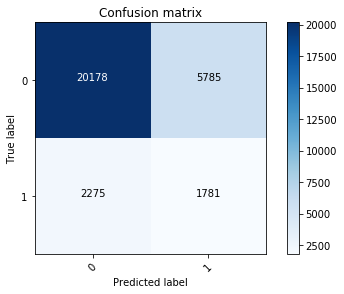

final score is:  0.5526178805076053


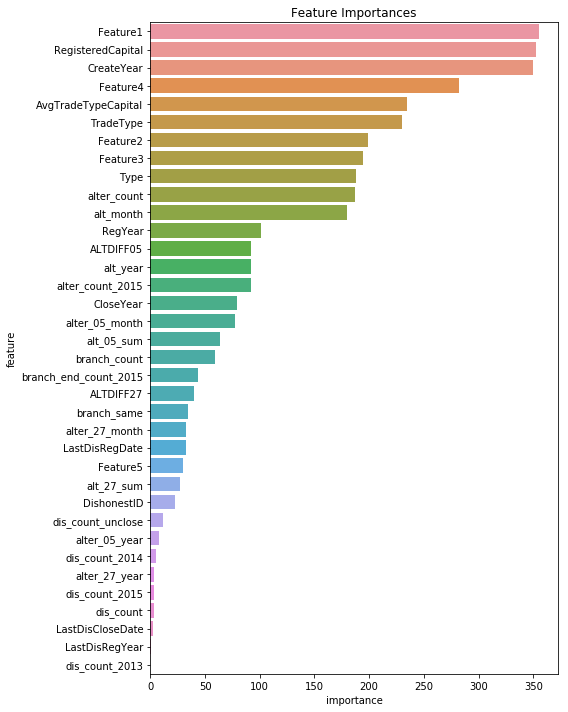

In [100]:
lgb_cv, f1_th = evaluate(X, y)

In [101]:
# 1. baseline  线下0.5506486251865143  线上0.54972363000
# 2. baseline+entbase特征工程   线下0.5522268849698447  线上0.55381292000
# 3. baseline+dishonest特征工程   线下0.5526178805076053   线上0.55403787000

# Pred

In [102]:
model = lgb.train(l_params, lgb.Dataset(X, label=y), len(lgb_cv['auc-mean']))
pred = model.predict(test.drop(['EID'], axis=1))

# Output

In [103]:
test['PROB'] = pred
sub = pd.DataFrame({'EID':test.EID, 'PROB':test.PROB})
sub.insert(1, 'Y', 0)

In [104]:
test_raw = pd.read_csv(PATH_DATA_RAW + "evaluation_public.csv")
del test_raw['Y']
del test_raw['PROB']

In [105]:
test_raw = test_raw.merge(sub,how='left',on='EID')

In [106]:
test_raw['Y'][test_raw['PROB'] >= f1_th] = 1

In [107]:
test_raw.to_csv('../submit/baseline_publish.csv',index=False, encoding = 'utf-8')